In [1]:
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from tqdm import tqdm
import argparse
import glob
import xml.etree.ElementTree as ET 
import cv2
import ast
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random
import sys

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# I. Generate CSV

In [3]:
path_an = "/kaggle/input/pcb-defects/PCB_DATASET/Annotations"
print(path_an)

/kaggle/input/pcb-defects/PCB_DATASET/Annotations


In [4]:
dataset = {
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
            "class":[],    
            "file":[],
            "width":[],
            "height":[],
           }
all_files = []
for path, subdirs, files in os.walk(path_an):
#     print([path, subdirs, files])
    for name in files:
        all_files.append(os.path.join(path, name))
    
print(type(dataset))
print(dataset)

<class 'dict'>
{'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'file': [], 'width': [], 'height': []}


In [5]:
for anno in all_files:
    # print(anno)
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        # print(elem)
        
        if 'size' in elem.tag:
            # print('[size] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            # print('[object] in elem.tag ==> list(elem)\n'), print(list(elem))
            for attr in list(elem):
                
                # print('attr = %s\n' % attr)
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['class']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]         

In [6]:
data=pd.DataFrame(dataset)
data

,xmin,ymin,xmax,ymax,class,file,width,height
0,1199,966,1234,1004,mouse_bite,01_mouse_bite_11,3034,1586
1,2042,755,2073,786,mouse_bite,01_mouse_bite_11,3034,1586
2,1472,607,1507,639,mouse_bite,01_mouse_bite_11,3034,1586
3,2168,854,2200,887,mouse_bite,01_mouse_bite_17,3034,1586
4,1513,919,1545,957,mouse_bite,01_mouse_bite_17,3034,1586
...,...,...,...,...,...,...,...,...
2948,706,892,741,991,spurious_copper,06_spurious_copper_09,2868,2316
2949,1055,1136,1114,1171,spurious_copper,06_spurious_copper_09,2868,2316
2950,1796,1019,1839,1089,spurious_copper,04_spurious_copper_04,3056,2464
2951,474,1236,527,1382,spurious_copper,04_spurious_copper_04,3056,2464


# II. Reading the CSV file

In [7]:
df = data.copy()
train, test = train_test_split(data, shuffle=True, test_size=0.2, random_state=34)

In [8]:
train.shape, test.shape, df.shape

((2362, 8), (591, 8), (2953, 8))

In [9]:
classes_la = {"missing_hole": 1, "mouse_bite": 2, "open_circuit":3, "short": 4, 'spur': 5,'spurious_copper':6}

df["class"] = df["class"].apply(lambda x: classes_la[x])
train["class"] = train["class"].apply(lambda x: classes_la[x])
test["class"] = test["class"].apply(lambda x: classes_la[x])

In [10]:
print("Data Frame Size ", len(df))
print("Train Size ", len(train))
print("Test Size ", len(test))

Data Frame Size  2953
Train Size  2362
Test Size  591


# III. Visualization 

In [11]:
def plot_image(image_name):
    print(image_name)
    image_group = data.groupby("file").get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    path ="/kaggle/input/pcb-defects/PCB_DATASET/images/"
    if "missing" in name.split('_'):
        path += 'Missing_hole/'
    if "mouse" in name.split('_'):
        path += 'Mouse_bite/'
    if "open" in name.split('_'):
        path += 'Open_circuit/'
    if "short" in name.split('_'):
        path += 'Short/'
    if "spur" in name.split('_'):
        path += 'Spur/'
    if "spurious" in name.split('_'):
        path += 'Spurious_copper/'
   
    img = immg.imread(path+""+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(box)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        # ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

12_spur_01
[1687  470 1749  570]
[1055  734 1167  794]
[1775 1228 1891 1277]
[1686 1821 1795 1868]
[ 887 1615 1007 1668]


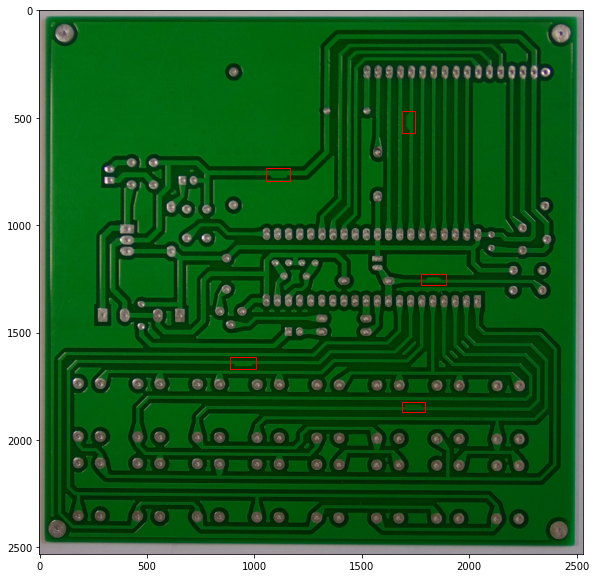

In [12]:
name = data.file[605]
plot_image(name)

# IV. Creating Custom database

In [13]:
class fcbData(object):
    def __init__(self, df, IMG_DIR, transforms): 
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['file'].unique().tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        a = ''
        if "missing" in image_id.split('_'):
            a = 'Missing_hole/'
        elif "mouse" in image_id.split('_'):
            a = 'Mouse_bite/'
        elif "open" in image_id.split('_'):
            a = 'Open_circuit/'
        elif "short" in image_id.split('_'):
            a = 'Short/'
        elif "spur" in image_id.split('_'):
            a = 'Spur/'
        elif "spurious" in image_id.split('_'):
            a = 'Spurious_copper/'
        image_values = self.df[self.df['file'] == image_id]
        image = cv2.imread(self.img_dir+a+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        labels = image_values["class"].values
        labels = torch.tensor(labels)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
        
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, image_id

Define the image transformations. We'll use albumentations package: https://albumentations.ai/


In [14]:
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [15]:
path ="/kaggle/input/pcb-defects/PCB_DATASET/images/"
fcb_dataset   = fcbData(df, path, get_train_transform())

In [16]:
len(fcb_dataset)

693

In [17]:
first_data=fcb_dataset[0]
type(first_data), len(first_data), type(first_data[0]), type(first_data[1]), type(first_data[2])

(tuple, 3, torch.Tensor, dict, str)

In [18]:
print(first_data[0], first_data[1], first_data[2])

tensor([[[0.5686, 0.5725, 0.5725,  ..., 0.6000, 0.6196, 0.6039],
         [0.5804, 0.5804, 0.5686,  ..., 0.6157, 0.6118, 0.5961],
         [0.5804, 0.5843, 0.5882,  ..., 0.6118, 0.6039, 0.5882],
         ...,
         [0.5490, 0.5451, 0.5686,  ..., 0.6039, 0.5882, 0.5961],
         [0.5647, 0.5686, 0.5569,  ..., 0.5882, 0.5882, 0.5804],
         [0.5647, 0.5686, 0.5569,  ..., 0.5882, 0.5922, 0.6039]],

        [[0.5333, 0.5373, 0.5373,  ..., 0.5765, 0.5961, 0.5804],
         [0.5412, 0.5412, 0.5333,  ..., 0.5922, 0.5882, 0.5725],
         [0.5412, 0.5451, 0.5490,  ..., 0.5882, 0.5804, 0.5647],
         ...,
         [0.5255, 0.5216, 0.5451,  ..., 0.5843, 0.5686, 0.5765],
         [0.5451, 0.5412, 0.5294,  ..., 0.5804, 0.5804, 0.5725],
         [0.5451, 0.5412, 0.5294,  ..., 0.5804, 0.5843, 0.5961]],

        [[0.5373, 0.5412, 0.5412,  ..., 0.5922, 0.6118, 0.5961],
         [0.5451, 0.5451, 0.5373,  ..., 0.6078, 0.6039, 0.5882],
         [0.5451, 0.5490, 0.5529,  ..., 0.6039, 0.5961, 0.

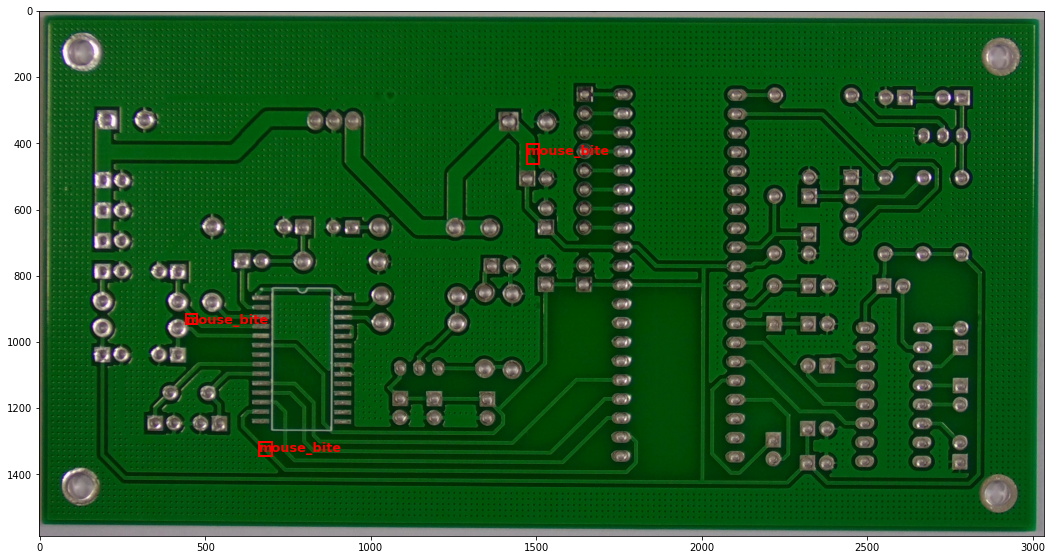

In [19]:
img, tar, _ = fcb_dataset[random.randint(0,50)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for j in tar["labels"].tolist():
    classes_la = {1:"missing_hole", 2: "mouse_bite", 3:"open_circuit",4: "short", 5:'spur',6:'spurious_copper'}
    l = classes_la[j]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

In [20]:
image_ids=df['file'].unique()
print(len(image_ids))

693


Split data into training and test

In [21]:
valid_df = train.sample(frac=0.1, random_state=42)
indices_to_remove = valid_df.index
train_df = train.drop(indices_to_remove)
test_df = test
train_df.shape,valid_df.shape

((2126, 8), (236, 8))

# V. Dataloader

In [22]:
path

'/kaggle/input/pcb-defects/PCB_DATASET/images/'

In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [24]:
train_dataset = fcbData(train_df, path, get_train_transform())
valid_dataset = fcbData(valid_df, path, get_valid_transform())
test_dataset  = fcbData(test_df , path, get_test_transform() )

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

In [25]:
print(len(train_data_loader),len(valid_data_loader),len(test_data_loader))

687 210 410


Most pretrained models are trained with a background class, we'll include it in our model, so in that case our number of classes will be 6

In [26]:
def load_model():
    ## num_classes = 6 # + background
    num_classes = 6+1

    # load a model; pre-trained on COCO
    # .. fpn = 'feature pyramid network'
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device ",device)

Using device  cuda


In [28]:
model=load_model()
for name, params in model.named_parameters():
    if params.requires_grad and name.__contains__("predict"):
        print(name)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

roi_heads.box_predictor.cls_score.weight
roi_heads.box_predictor.cls_score.bias
roi_heads.box_predictor.bbox_pred.weight
roi_heads.box_predictor.bbox_pred.bias


In [29]:
def load_params():
    model=load_model().to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005,)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    return model,params,optimizer,lr_scheduler

# VI. Training and evaluation

In [30]:
train_data_loader

In [31]:
def orthogonal_loss(lembda):
    extra_norm=0.
    for m in model.modules():
        if isinstance(m,torch.nn.Linear) or isinstance(m,torch.nn.Conv2d):
            tmp=m.weight.view(m.weight.data.size(0), -1) 
            s1,s2=tmp.shape # For unequal matrices semi orthogonal condition is imposed
            if s1<s2:
                extra_norm+=torch.norm(torch.mm(tmp,tmp.t())-torch.eye(s1).to(device),p='fro')
            else:
                extra_norm+=torch.norm(torch.mm(tmp.t(),tmp)-torch.eye(s2).to(device),p='fro')
    return lembda*extra_norm

In [32]:
lembdas = [0.,0.0001,0.001,0.01]
loss_curves = []
IOU_curves = []
models  = []

for lembda in lembdas:
    
    min_loss = sys.maxsize
    num_epochs = 10
    
    model=load_model().to(device)
    models.append(model)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005,)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    loss_curve=[]
    IOU_curve=[]
    
    for epoch in range(num_epochs):
        tk = tqdm(train_data_loader)
        model.train()
        running_loss = 0.
        for images, targets, image_ids in tk:
            # Shifting everything to CUDA (NO CHANGE IN DATA)
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses + orthogonal_loss(lembda)
            running_loss+=loss_value.item()
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            loss_curve.append(loss_value.item())
            tk.set_postfix(train_loss=loss_value.item())
        tk.close()
        running_loss/=len(train_data_loader)
        loss_curve.append(running_loss)
        
        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()
        
        print(f"Epoch #{epoch} loss: {loss_value.item()}")
        
        #validation
        model.eval();
        with torch.no_grad():
            tk = tqdm(valid_data_loader)
            running_IOU=0.
            for images, targets, image_ids in tk:
                # Shifting everthing to CUDA (NO CHANGE IN DATA)
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                val_output = model(images)
                val_output = [{k: v.to(device) for k, v in t.items()} for t in val_output]
                IOU = []
                for j in range(len(val_output)):
                    a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                    chk = torchvision.ops.box_iou(a,b)
                    res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                    if np.isnan(res):
                        res = 0.0
                    IOU.append(res)
                running_IOU += np.nanmean(IOU)
                tk.set_postfix(IoU=np.nanmean(IOU))
            running_IOU/=len(valid_data_loader)
            IOU_curve.append(running_IOU)
            tk.close()
        print("IOU Average Measure ",IOU_curve[-1])
    IOU_curves.append(IOU_curve)
    loss_curves.append(loss_curve)
    models.append(model)

  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #0 loss: 0.4154735207093784


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5099490593405216


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #1 loss: 0.18291623968824272


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5279677307808907


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #2 loss: 0.24889991916304266


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5465601651863511


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #3 loss: 0.26828299662117777


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6694342524915092


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #4 loss: 0.2117612687992491


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6975141420530391


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #5 loss: 0.2628750306998274


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6960117040025408


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #6 loss: 0.20925709532862527


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6991656492587713


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #7 loss: 0.13705977608989153


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7018036612915435


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #8 loss: 0.06664668099575047


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7021747987496777


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #9 loss: 0.1984546782526804


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7024011528011818


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #0 loss: 0.29972054510047186


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.4920621145817995


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #1 loss: 0.27581788623029313


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5014471726551939


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #2 loss: 0.34351769471644455


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5531726773915323


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #3 loss: 0.31450855824536417


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6644558231634056


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #4 loss: 0.2229993838031239


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6787015994220867


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #5 loss: 0.2744281756987843


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6865774222362394


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #6 loss: 0.23667718352452768


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.684385229686991


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #7 loss: 0.35655379512672586


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6821018473513208


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #8 loss: 0.29844008338988104


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6842537118651509


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #9 loss: 0.25629042126663826


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.686156064599214


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #0 loss: 1.2078534810018995


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5009889977293002


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #1 loss: 1.6122883519615785


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.524427144382264


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #2 loss: 1.086878409582372


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6073063894075722


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #3 loss: 1.1810410398962974


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.682465203939878


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #4 loss: 1.143793378951004


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.697119173524543


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #5 loss: 1.0270604194283701


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.7116309339994006


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #6 loss: 1.1430963051997525


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6986975582257622


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #7 loss: 1.0487306844878825


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6992028372643294


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #8 loss: 1.10863712016254


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6990748839063483


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #9 loss: 1.0777577746139642


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.700103781401715


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #0 loss: 7.37370073060206


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.41837636443128096


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #1 loss: 5.828604576056244


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5537179057577023


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #2 loss: 4.940755517591674


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.5758026706395925


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #3 loss: 4.662734189659487


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6707687098178551


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #4 loss: 4.778374173467254


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.686105420147832


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #5 loss: 4.704785074848226


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6899389789067613


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #6 loss: 4.415420241625114


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6984085035707422


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #7 loss: 4.4724257863540045


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.6917563992808174


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #8 loss: 4.572945058122941


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.691827806516462


  0%|          | 0/687 [00:00<?, ?it/s]

Epoch #9 loss: 4.4623083959384715


  0%|          | 0/210 [00:00<?, ?it/s]

IOU Average Measure  0.688870888667048


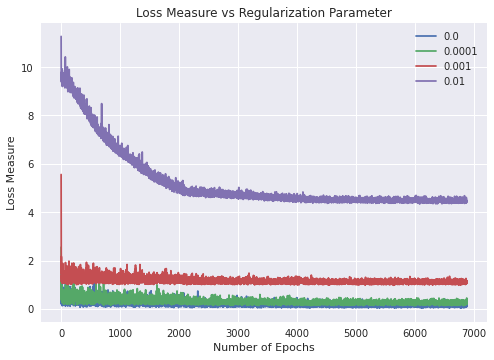

In [33]:
plt.style.use('seaborn')
for lc,l in zip(loss_curves,lembdas):
    plt.plot(lc,label=l)
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Measure")
plt.title("Loss Measure vs Regularization Parameter")
plt.savefig('loss_curves.png')
plt.show()

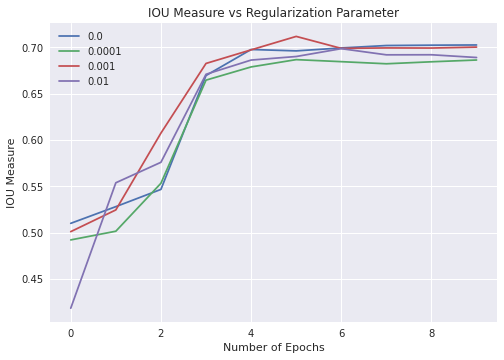

In [34]:
for ic,l in zip(IOU_curves,lembdas):
    plt.plot(ic,label=l)
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("IOU Measure")
plt.title("IOU Measure vs Regularization Parameter")
plt.savefig('iou_curves.png')
plt.show()

##### Sample evaluation on validation dataset image

In [35]:
img,target,_ = valid_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))

predicted #boxes:  5
real #boxes:  1


In [36]:
for model,lembda in zip(models,lembdas):
    model_path = 'model_{}.pth'.format(lembda)
    torch.save(model.state_dict(),model_path)

# VII. Evaluation

In [37]:
# y_true =[]
# y_pred = []
# for data in valid_dataset:
#     img,target,_ = data
#     model.eval()
#     with torch.no_grad():
#         y_true.append(target['labels'][0])
#         prediction = model([img.to(device)])[0]
#         if len(prediction['labels'])==0:
#             y_pred.append(torch.tensor(0).to(device))
#         else:
#             y_pred.append(prediction['labels'][0])

In [38]:
# yy_pred = []
# for v in y_pred:
#     yy_pred.append(v.cpu())

In [39]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_true, yy_pred)

In [40]:
# from sklearn.metrics import classification_report
# print(classification_report(y_true, yy_pred))

In [41]:
# # Define the device for inference (CPU or GPU)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# defect_names = {
#     1: "Missing Hole",
#     2: "Open Circuit",
#     3: "Short Circuit",
#     4: "Mouse Bite",
#     5: "Spur",
#     6: "Copper Trace Cut"
# }
# # Load the model
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=7)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=7)
# model.load_state_dict(torch.load('/kaggle/working/pcbdetection.pt'))
# model.eval()
# model.to(device)

# # Load the image
# image_path = '/kaggle/input/pcb-defects/PCB_DATASET/images/Mouse_bite/01_mouse_bite_06.jpg'
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = image / 255.0

# # Define the transformation to apply to the image
# transform = T.Compose([T.ToTensor()])

# # Apply the transformation to the image
# image = transform(image).to(device)

# # Predict the bounding boxes and labels for the image
# image = image.float()
# outputs = model([image])
# boxes = outputs[0]['boxes'].detach().cpu().numpy()
# labels = outputs[0]['labels'].detach().cpu().numpy()

# # Visualize the image and the predicted bounding boxes
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.imshow(image.permute(1, 2, 0).cpu().numpy())
# for box, label in zip(boxes, labels):
#     x1, y1, x2, y2 = box
#     w, h = x2 - x1, y2 - y1
#     rect = matplotlib.patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
#     ax.text(x1-20, y2 + 150, defect_names[label], fontsize=12, color='g', backgroundcolor='w')
# plt.show()

# VIII. Testing Results